In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
import ast
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.models import load_model
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('clean_avis_v1.csv')
del(df['Unnamed: 0'])
df['avis_token_en'] = df['avis_token_en'].apply(ast.literal_eval)
df['avis_token_fr'] = df['avis_token_fr'].apply(ast.literal_eval)



In [6]:
df.dropna(inplace=True)

In [3]:
df.head()

,note,assureur,produit,date_exp,avis_cor,avis_cor_en,avis_clean_fr,avis_clean_en,avis_token_fr,avis_token_en
0,5.0,Direct Assurance,auto,01/09/2021,"Meilleurs assurances , prix , solutions , écou...","Best insurance , price , solutions , listening...",meilleurs assurances prix solutions écoute rap...,best insurance price solutions listening speed...,"[meilleurs, assurances, prix, solutions, écout...","[best, insurance, price, solutions, listening,..."
1,4.0,Direct Assurance,auto,01/05/2021,"je suis globalement satisfait , sauf que vous ...","I am generally satisfied , except that you hav...",globalement satisfait sauf problème site inter...,generally satisfied except problem website imp...,"[globalement, satisfait, sauf, problème, site,...","[generally, satisfied, except, problem, websit..."
2,5.0,Direct Assurance,auto,01/03/2021,Prix tres abordable plusieurs options s'offren...,Very affordable price Several options are avai...,prix tres abordable plusieurs options soffrent...,affordable price several options available us ...,"[prix, tres, abordable, plusieurs, options, so...","[affordable, price, several, options, availabl..."
3,4.0,L'olivier Assurance,auto,01/06/2021,"je satisfait du service , une réponse très rap...","I satisfy the service , a very fast response f...",satisfait service réponse très rapide service ...,satisfy service fast response service thank ch...,"[satisfait, service, réponse, très, rapide, se...","[satisfy, service, fast, response, service, th..."
4,1.0,Matmut,auto,01/01/2017,"Client depuis plus de 25 ans , très déçu de ce...","Customer for more than 25 years , very disappo...",client depuis plus ans très déçu cette mutuel...,customer years disappointed mutual longer mut...,"[client, depuis, ans, très, déçu, mutuelle, ri...","[customer, years, disappointed, mutual, longer..."


# TF-IDF

In [7]:



X_train, X_test, y_train, y_test = train_test_split(
    df['avis_clean_en'], df['note'], test_size=0.2, random_state=42
)

tfidf_vectorizer = TfidfVectorizer(max_features=5000) 
classifier = MultinomialNB()

model = Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('classifier', classifier)
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_rep)



Accuracy: 0.53
Classification Report:
               precision    recall  f1-score   support

         1.0       0.56      0.96      0.71      1441
         2.0       0.34      0.03      0.05       691
         3.0       0.29      0.04      0.07       665
         4.0       0.45      0.43      0.44       979
         5.0       0.53      0.67      0.59       926

    accuracy                           0.53      4702
   macro avg       0.44      0.43      0.37      4702
weighted avg       0.46      0.53      0.44      4702



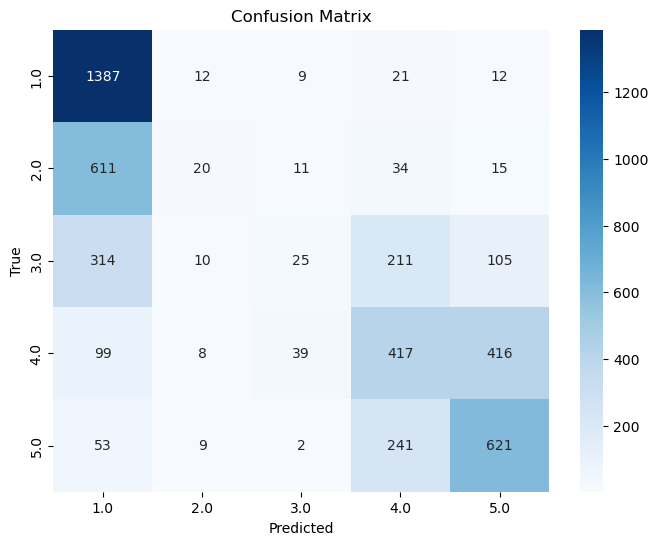

In [8]:


cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(df['note'].unique()), yticklabels=sorted(df['note'].unique()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Embedding layer

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences


X_train, X_test, y_train, y_test = train_test_split(
    df['avis_clean_en'], df['note'], test_size=0.2, random_state=42
)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

max_words = 620  
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

max_sequence_length = max(len(seq) for seq in X_train_sequences)
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length, padding='post')

embedding_dim = 50  
model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_sequence_length),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='val_accuracy', mode='auto', verbose=0,patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
model.compile(optimizer='adam', loss ='sparse_categorical_crossentropy', metrics = ['accuracy'])
history =model.fit(X_train_padded, y_train_encoded, epochs=50, validation_data=(X_test_padded, y_test_encoded),callbacks=[es, mc])


y_pred_prob = model.predict(X_test_padded)
y_pred = y_pred_prob.argmax(axis=-1)
y_pred_labels = label_encoder.inverse_transform(y_pred)

accuracy = accuracy_score(y_test, y_pred_labels)
classification_rep = classification_report(y_test, y_pred_labels)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_rep)


Epoch 1/50
586/588 [============================>.] - ETA: 0s - loss: 1.1986 - accuracy: 0.4681
Epoch 1: val_accuracy improved from -inf to 0.50510, saving model to best_model.h5
588/588 [==============================] - 11s 18ms/step - loss: 1.1984 - accuracy: 0.4683 - val_loss: 1.1153 - val_accuracy: 0.5051
Epoch 2/50
  5/588 [..............................] - ETA: 9s - loss: 1.1868 - accuracy: 0.4375

C:\Users\paulr\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


586/588 [============================>.] - ETA: 0s - loss: 1.0732 - accuracy: 0.5114
Epoch 2: val_accuracy improved from 0.50510 to 0.51531, saving model to best_model.h5
588/588 [==============================] - 10s 17ms/step - loss: 1.0737 - accuracy: 0.5111 - val_loss: 1.1003 - val_accuracy: 0.5153
Epoch 3/50
585/588 [============================>.] - ETA: 0s - loss: 1.0037 - accuracy: 0.5527
Epoch 3: val_accuracy did not improve from 0.51531
588/588 [==============================] - 10s 17ms/step - loss: 1.0040 - accuracy: 0.5525 - val_loss: 1.1127 - val_accuracy: 0.5026
Epoch 4/50
586/588 [============================>.] - ETA: 0s - loss: 0.8981 - accuracy: 0.6119
Epoch 4: val_accuracy did not improve from 0.51531
588/588 [==============================] - 10s 17ms/step - loss: 0.8980 - accuracy: 0.6119 - val_loss: 1.1608 - val_accuracy: 0.4798
Epoch 5/50
587/588 [============================>.] - ETA: 0s - loss: 0.7803 - accuracy: 0.6721
Epoch 5: val_accuracy did not improve fr

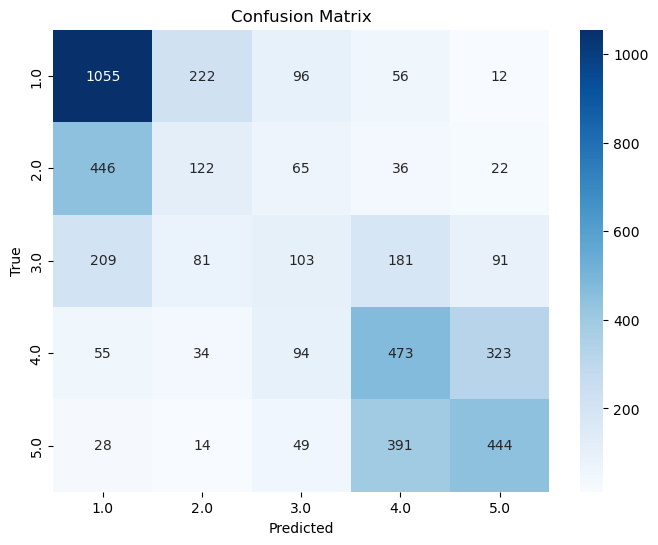

In [23]:

cm = confusion_matrix(y_test, y_pred_labels)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(df['note'].unique()), yticklabels=sorted(df['note'].unique()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Pre-trained embedding layer

In [39]:


X_train, X_test, y_train, y_test = train_test_split(
    df['avis_clean_en'], df['note'], test_size=0.2, random_state=42
)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

max_words = 5000
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

max_sequence_length = max(len(seq) for seq in X_train_sequences)
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length, padding='post')

embedding_dim = 50
embedding_matrix = np.zeros((max_words, embedding_dim))

glove_path = 'glove.6B.50d.txt'

with open(glove_path, 'r', encoding='utf-8') as glove_file:
    for line in glove_file:
        values = line.split()
        word = values[0]
        if word in tokenizer.word_index and tokenizer.word_index[word] < max_words:
            embedding_matrix[tokenizer.word_index[word]] = np.array(values[1:], dtype='float32')

model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, weights=[embedding_matrix], 
              input_length=max_sequence_length, trainable=False),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='val_accuracy', mode='auto', verbose=0,patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
model.compile(optimizer='adam', loss ='sparse_categorical_crossentropy', metrics = ['accuracy'])
history =model.fit(X_train_padded, y_train_encoded, epochs=50, validation_data=(X_test_padded, y_test_encoded),callbacks=[es, mc])

y_pred_prob = model.predict(X_test_padded)
y_pred = y_pred_prob.argmax(axis=-1)
y_pred_labels = label_encoder.inverse_transform(y_pred)

accuracy = accuracy_score(y_test, y_pred_labels)
classification_rep = classification_report(y_test, y_pred_labels)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_rep)


Epoch 1/50
586/588 [============================>.] - ETA: 0s - loss: 1.2463 - accuracy: 0.4560
Epoch 1: val_accuracy improved from -inf to 0.47235, saving model to best_model.h5
588/588 [==============================] - 11s 18ms/step - loss: 1.2467 - accuracy: 0.4556 - val_loss: 1.1877 - val_accuracy: 0.4724
Epoch 2/50
  8/588 [..............................] - ETA: 9s - loss: 1.1681 - accuracy: 0.4922

C:\Users\paulr\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


587/588 [============================>.] - ETA: 0s - loss: 1.1114 - accuracy: 0.5147
Epoch 2: val_accuracy improved from 0.47235 to 0.50298, saving model to best_model.h5
588/588 [==============================] - 11s 19ms/step - loss: 1.1114 - accuracy: 0.5147 - val_loss: 1.1378 - val_accuracy: 0.5030
Epoch 3/50
585/588 [============================>.] - ETA: 0s - loss: 1.0361 - accuracy: 0.5495
Epoch 3: val_accuracy did not improve from 0.50298
588/588 [==============================] - 12s 20ms/step - loss: 1.0365 - accuracy: 0.5493 - val_loss: 1.1561 - val_accuracy: 0.4921
Epoch 4/50
587/588 [============================>.] - ETA: 0s - loss: 0.9640 - accuracy: 0.5843
Epoch 4: val_accuracy did not improve from 0.50298
588/588 [==============================] - 12s 20ms/step - loss: 0.9640 - accuracy: 0.5842 - val_loss: 1.1951 - val_accuracy: 0.4834
Epoch 5/50
585/588 [============================>.] - ETA: 0s - loss: 0.8786 - accuracy: 0.6253
Epoch 5: val_accuracy did not improve fr

In [54]:

cm = confusion_matrix(y_test, y_pred_labels)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(df['note'].unique()), yticklabels=sorted(df['note'].unique()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [4701, 4702]

# USE

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    df['avis_clean_en'], df['note'], test_size=0.2, random_state=42
)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

use_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
embed = hub.load(use_url)

X_train_embed = embed(X_train)
X_test_embed = embed(X_test)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(512,)), 
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])

es = EarlyStopping(monitor='val_accuracy', mode='auto', verbose=0, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_embed, y_train_encoded, epochs=50, validation_data=(X_test_embed, y_test_encoded), callbacks=[es, mc])

y_pred_prob = model.predict(X_test_embed)
y_pred = y_pred_prob.argmax(axis=-1)
y_pred_labels = label_encoder.inverse_transform(y_pred)

accuracy = accuracy_score(y_test, y_pred_labels)
classification_rep = classification_report(y_test, y_pred_labels)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_rep)


Epoch 1/50
588/588 [==============================] - ETA: 0s - loss: 1.1668 - accuracy: 0.4921
Epoch 1: val_accuracy improved from -inf to 0.50702, saving model to best_model.h5
588/588 [==============================] - 1s 2ms/step - loss: 1.1668 - accuracy: 0.4921 - val_loss: 1.1253 - val_accuracy: 0.5070
Epoch 2/50
110/588 [====>.........................] - ETA: 0s - loss: 1.1015 - accuracy: 0.5185

C:\Users\paulr\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


573/588 [============================>.] - ETA: 0s - loss: 1.1021 - accuracy: 0.5157
Epoch 2: val_accuracy improved from 0.50702 to 0.51085, saving model to best_model.h5
588/588 [==============================] - 1s 2ms/step - loss: 1.1025 - accuracy: 0.5155 - val_loss: 1.1208 - val_accuracy: 0.5108
Epoch 3/50
550/588 [===========================>..] - ETA: 0s - loss: 1.0830 - accuracy: 0.5240
Epoch 3: val_accuracy did not improve from 0.51085
588/588 [==============================] - 1s 2ms/step - loss: 1.0831 - accuracy: 0.5244 - val_loss: 1.1286 - val_accuracy: 0.4945
Epoch 4/50
579/588 [============================>.] - ETA: 0s - loss: 1.0609 - accuracy: 0.5386
Epoch 4: val_accuracy did not improve from 0.51085
588/588 [==============================] - 1s 2ms/step - loss: 1.0611 - accuracy: 0.5387 - val_loss: 1.1239 - val_accuracy: 0.5081
Epoch 5/50
571/588 [============================>.] - ETA: 0s - loss: 1.0385 - accuracy: 0.5528
Epoch 5: val_accuracy did not improve from 0.5

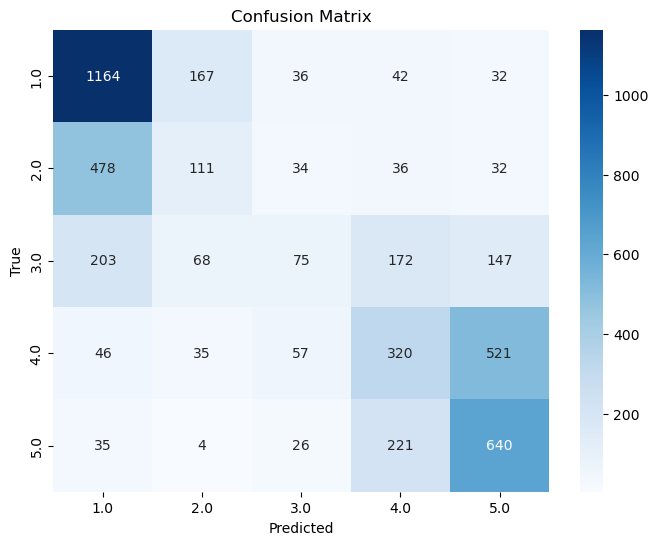

In [37]:

cm = confusion_matrix(y_test, y_pred_labels)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(df['note'].unique()), yticklabels=sorted(df['note'].unique()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()